In [35]:
import networkx as nx 
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import torch

from gsnn.models.GSNN import GSNN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.datasets import simulate_3_in_3_out
from gsnn.interpret.GSNNExplainer import GSNNExplainer
from gsnn.interpret.IGExplainer import IGExplainer
from gsnn.interpret.ContrastiveIGExplainer import ContrastiveIGExplainer
from gsnn.interpret.NoiseTunnel import NoiseTunnel
from gsnn.interpret.ContrastiveOcclusionExplainer import ContrastiveOcclusionExplainer
from gsnn.interpret.OcclusionExplainer import OcclusionExplainer
from gsnn.interpret.utils import plot_edge_importance
from gsnn.interpret.CounterfactualExplainer import CounterfactualExplainer

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GSNN Interpretation methods 


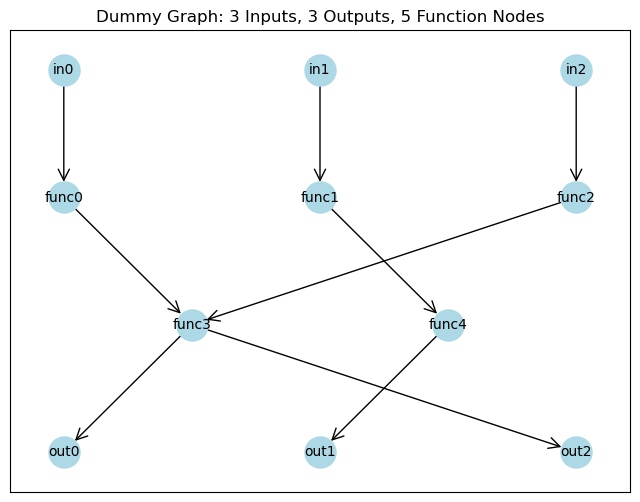

In [2]:
G, pos, x_train, x_test, y_train, y_test, \
    input_nodes, function_nodes, output_nodes = simulate_3_in_3_out(n_train=500, 
                                                                    n_test=100, 
                                                                    noise_scale=0.1, 
                                                                    device='cuda')

plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             channels=20, 
             layers=2,
             dropout=0.,
             share_layers=True, 
             bias=False,
             add_function_self_edges=False,
             checkpoint=False, 
             norm='batch', 
             residual=True).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)
crit = torch.nn.MSELoss()

for i in range(1000):
    model.train() 
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()
    
    model.eval() 
    with torch.no_grad():
        yhat = model(x_test)
        loss = crit(y_test, yhat)

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

model = model.eval()

n params 240


## Explanations of *multiple* observations with `GSNNExplainer`


The GSNN explainer method is inspired by GNNExplainer proposed by Ying et. al., however, our approaches diverges slightly in a number of ways:  
 
1. We use MSE rather than mutual information as the optimization objective   
2. We use gumbel-softmax to discretize edge weights [0,1]   
3. We focus on edge explanations rather than node or feature explanations  

```
@misc{ying2019gnnexplainergeneratingexplanationsgraph,
      title={GNNExplainer: Generating Explanations for Graph Neural Networks}, 
      author={Rex Ying and Dylan Bourgeois and Jiaxuan You and Marinka Zitnik and Jure Leskovec},
      year={2019},
      eprint={1903.03894},
      archivePrefix={arXiv},
      primaryClass={cs.LG},
      url={https://arxiv.org/abs/1903.03894}, 
}
```

GSNNExplainer attempts to identify a minimal subgraph that can faithfully reproduce equivalent predictions. This explanation can be used with multiple samples and targets. The resulting edge scores indicate the probability of inclusion: 

$e_i -> 1$ : indicates the edge is important for the prediction   
$e_i -> 0$ : indicates the edge is not important for the prediction   

NOTE: in it's current formulation, it is important to tune the parameters to ensure faithful predictions. Using too strong of regularization (large beta) can result in unfaithful predictions. 

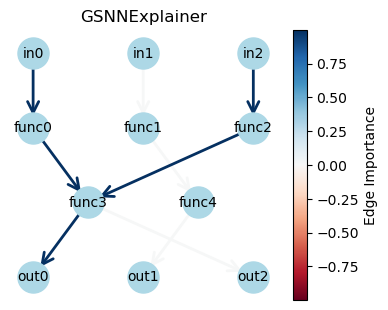

In [19]:
target_ixs = [0]

explainer = GSNNExplainer(model, data, ignore_cuda=False, gumbel_softmax=True, hard=False, tau0=10, min_tau=0.5, 
                            prior=0, iters=500, lr=1e-2, weight_decay=0, 
                                    beta=1e-2, verbose=True, optimizer=torch.optim.Adam, free_edges=0)

res = explainer.explain(x_train, targets=target_ixs)                                     

plot_edge_importance(res, pos, title='GSNNExplainer')

## Explanations of a *single* observation with `Integrated Gradients`

"What latent edge features are responsible for an observations predicted outcome?" 

The returned edge attribution indicates:    
 IGₑ > 0 adding edge e increases predicted value   
 IGₑ < 0 adding edge e decreases predicted value   
 IGₑ ≈ 0 edge e is irrelevant to the predicted value   

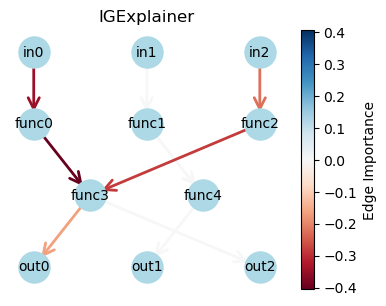

,source,target,score
1,func1,func4,0.000000
4,in1,func1,0.000000
7,func3,out2,0.000000
8,func4,out1,0.000000
6,func3,out0,-0.165093
5,in2,func2,-0.222546
2,func2,func3,-0.285295
3,in0,func0,-0.349832
0,func0,func3,-0.406115


In [30]:
x = x_train[[0]]
y = y_train[[0]]
target_ixs = [0] 

explainer = IGExplainer(model, data)

res = explainer.explain(x, target_idx=target_ixs)
res = res.sort_values('score', ascending=False)

plot_edge_importance(res, pos, title='IGExplainer')
res.sort_values('score', ascending=False)

## Occlusion Explainer 

y[tidx]-> -1.6586637496948242
yhat[tidx]-> -1.4279669523239136


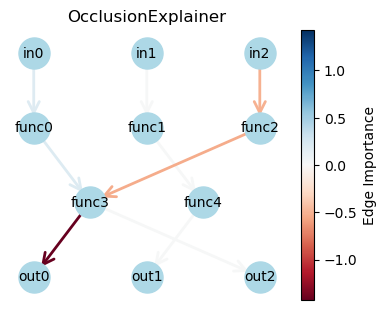

,source,target,score
0,func0,func3,1.960911e-01
3,in0,func0,1.788014e-01
1,func1,func4,2.384186e-07
4,in1,func1,0.000000e+00
7,func3,out2,0.000000e+00
8,func4,out1,0.000000e+00
5,in2,func2,-5.052041e-01
2,func2,func3,-5.264791e-01
6,func3,out0,-1.427967e+00


In [28]:
tidx = 0 
x = x_train[[0]]
y = y_train[[0]][:,tidx].item()
yhat = model(x.cuda())[:,tidx].item()
print('y[tidx]->', y)
print('yhat[tidx]->', yhat)

explainer = OcclusionExplainer(model, data, batch_size=64)
res = explainer.explain(x, target_idx=tidx)

plot_edge_importance(res, pos, title='OcclusionExplainer')
res.sort_values('score', ascending=False)

## *Contrastive* explanations between two observations 

"What latent edge features are responsible for the difference between two observations predicted outcome?" 

The returned edge attribution indicates:  
 IGₑ > 0 adding edge e enlarges the prediction gap  
 IGₑ < 0 adding edge e shrinks the gap  
 IGₑ ≈ 0 edge e is irrelevant to the gap.  

For this example, we focus on output `out0` and fix `in2` to 5 for both observations, suggesting that the difference in outcome should be explained by the path from `in0`->`func0`->`func3`->`out0`. 

In [22]:
target = 0 

x1 = torch.tensor([[0, 0, 5]], dtype=torch.float32)
x2 = torch.tensor([[-5, 0, 5]], dtype=torch.float32)

yhat1 = model(x1.cuda())[:, target]
yhat2 = model(x2.cuda())[:, target]
delta = yhat1 - yhat2 

print('yhat1', yhat1.item())
print('yhat2', yhat2.item())
print('delta', delta.item())

yhat1 -7.93367338180542
yhat2 -16.242734909057617
delta 8.309061050415039


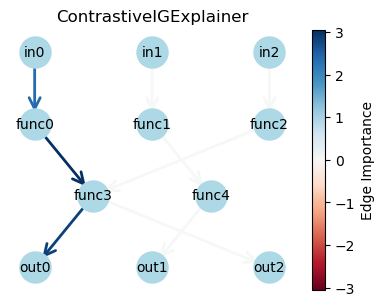

,source,target,score
0,func0,func3,3.057093
6,func3,out0,2.865155
3,in0,func0,2.370626
2,func2,func3,0.009792
5,in2,func2,0.006752
1,func1,func4,0.000000
4,in1,func1,0.000000
7,func3,out2,0.000000
8,func4,out1,0.000000


In [32]:
explainer = ContrastiveIGExplainer(model, data, n_steps=100) 

res = explainer.explain(x1, x2, target_idx=target)  

plot_edge_importance(res, pos, title='ContrastiveIGExplainer')
res.sort_values('score', ascending=False)

## `NoiseTunnel` can improve explanation robustness 

In some cases, injecting noise can help provide more robust explanations. More information [here](https://captum.ai/api/noise_tunnel.html). In this example, it is comparable to contrastive_ig. 

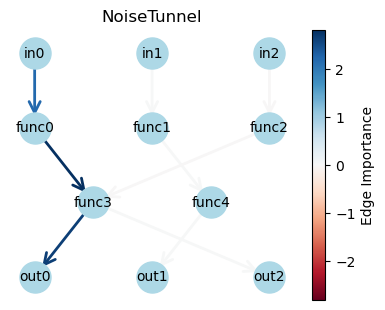

,source,target,score
0,func0,func3,2.806865
6,func3,out0,2.648054
3,in0,func0,2.213285
1,func1,func4,0.000000
4,in1,func1,0.000000
7,func3,out2,0.000000
8,func4,out1,0.000000
5,in2,func2,-0.004162
2,func2,func3,-0.004414


In [33]:
explainer = NoiseTunnel(contrastive_ig, n_samples=100, noise_std=0.1, agg='mean')

res = explainer.explain(x1, x2, target_idx=target)  

plot_edge_importance(res, pos, title='NoiseTunnel')
res.sort_values('score', ascending=False)

## Contrastive Occlusion Explainer 

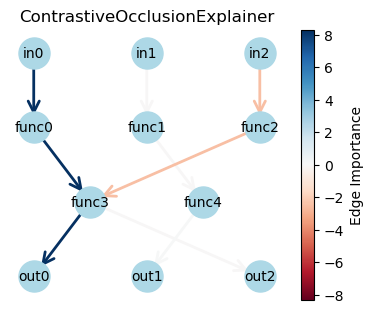

,source,target,score
0,func0,func3,8.309061
3,in0,func0,8.309061
6,func3,out0,8.309061
8,func4,out1,0.000000
1,func1,func4,-0.000002
4,in1,func1,-0.000002
7,func3,out2,-0.000002
5,in2,func2,-2.499346
2,func2,func3,-2.528114


In [34]:
explainer = ContrastiveOcclusionExplainer(model, data)

res = explainer.explain(x1, x2, target_idx=target)  

plot_edge_importance(res, pos, title='ContrastiveOcclusionExplainer')
res.sort_values('score', ascending=False)

## Counterfactual explanations 

The goal of this approach will be to understand what minimal changes to inputs (x) can be made to change the predicted outcome to a desired value. This can be used in tandem with contrastive explainers to understand the latent changes involved in the counterfactual response. 

In [46]:
x = x_train[[0]]
y = y_train[[0]]
yhat = model(x.cuda())
target_ixs = [0] 

# summary statistics 
print('y[tidx]->', y[:,target_ixs])
print('yhat[tidx]->', yhat[:,target_ixs]) 
print('x ->', x)

explainer = CounterfactualExplainer(model, data)

res = explainer.explain(x, target_value=0.5, target_idx=target_ixs)

y[tidx]-> tensor([[-1.6587]], device='cuda:0')
yhat[tidx]-> tensor([[-1.4280]], device='cuda:0', grad_fn=<IndexBackward0>)
x -> tensor([[1.7641, 0.4002, 0.9787]], device='cuda:0')
Converged at iteration 9111442


In [41]:
res.head() 

,feature,original,perturbation,counterfactual
0,feature_0,1.764052,-1.210720,0.553332
1,feature_1,0.400157,0.000000,0.400157
2,feature_2,0.978738,-1.274838,-0.296100
